# Imports

In [39]:
#Imports
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import lightgbm as lgb
from scipy.stats import spearmanr

sns.set_style("white")
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline
set_matplotlib_formats('svg')

plt.rcParams["font.family"] = "Times New Roman" # !!!!
plt.rcParams.update({'font.size': 32})


/tmp/ipykernel_873/3791004227.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Loading Files

In [40]:
df_config = pd.read_csv("../data/train_mixture_1m_climb.csv")
df_config = df_config.reindex(sorted(df_config.columns), axis=1)
df_config.head()

,index,train_cluster_1,train_cluster_10,train_cluster_11,train_cluster_12,train_cluster_13,train_cluster_14,train_cluster_15,train_cluster_16,train_cluster_17,...,train_cluster_19,train_cluster_2,train_cluster_20,train_cluster_3,train_cluster_4,train_cluster_5,train_cluster_6,train_cluster_7,train_cluster_8,train_cluster_9
0,1,0.0012,0.0000,0.0018,0.0004,0.0000,0.000,0.0,0.0000,0.3644,...,0.0002,0.0000,0.5238,0.0028,0.1046,0.0000,0.0000,0.0000,0.0000,0.0
1,2,0.0000,0.0000,0.0000,0.0470,0.0000,0.003,0.0,0.0000,0.0000,...,0.2484,0.2822,0.0000,0.3516,0.0000,0.0678,0.0000,0.0000,0.0000,0.0
2,3,0.0000,0.0000,0.0000,0.0016,0.0146,0.000,0.0,0.4716,0.0014,...,0.0002,0.0000,0.0010,0.0300,0.0332,0.0266,0.0940,0.0606,0.0000,0.0
3,4,0.0018,0.0000,0.3480,0.0000,0.0000,0.000,0.0,0.0000,0.0010,...,0.0000,0.1064,0.0040,0.1498,0.0914,0.0858,0.0466,0.1572,0.0082,0.0
4,5,0.0000,0.2464,0.0000,0.1568,0.0000,0.000,0.0,0.0206,0.0548,...,0.0088,0.0472,0.0326,0.0984,0.0836,0.1508,0.0528,0.0432,0.0038,0.0


In [41]:
df_wandb = pd.read_csv("../data/train_loss_1m_climb.csv")
df_wandb = df_wandb.reindex(sorted(df_wandb.columns), axis=1)
df_wandb.head()


,index,metric/task_arc_challenge_val_loss,metric/task_arc_easy_val_loss,metric/task_gsm8k_val_loss,metric/task_hellaswag_val_loss,metric/task_kodcode_val_loss,metric/task_logiqa_val_loss,metric/task_mathqa_val_loss,metric/task_medqa_val_loss,metric/task_piqa_val_loss,metric/task_sciq_val_loss
0,1,5.741854,5.867223,5.989934,5.584449,5.416245,5.184987,6.507051,4.675002,6.128508,5.196412
1,2,6.082568,6.263376,5.918647,5.629516,5.506816,5.308795,6.402447,5.950063,6.234870,5.892951
2,3,5.555756,5.688022,6.003356,5.600509,4.992914,5.209438,6.440838,5.595061,6.230780,4.996587
3,4,5.619822,5.748965,5.906838,5.548438,3.684155,5.238674,6.332462,5.786517,6.097181,5.240842
4,5,5.642646,5.785117,5.884056,5.489650,5.078591,5.148181,6.337667,4.967196,5.905982,5.030748


In [42]:
X_train = df_config[df_config.columns[1:]].values
X_train.shape

(512, 20)

In [43]:
y_train = df_wandb[df_wandb.columns[1:]].values
y_train.shape

(512, 10)

In [44]:
df_config = pd.read_csv("../data/test_mixture_1m_climb.csv")
df_config = df_config.reindex(sorted(df_config.columns), axis=1)
# df_config = df_config.head(105)
df_config

,index,train_cluster_1,train_cluster_10,train_cluster_11,train_cluster_12,train_cluster_13,train_cluster_14,train_cluster_15,train_cluster_16,train_cluster_17,...,train_cluster_19,train_cluster_2,train_cluster_20,train_cluster_3,train_cluster_4,train_cluster_5,train_cluster_6,train_cluster_7,train_cluster_8,train_cluster_9
0,513,0.0000,0.2726,0.0000,0.0096,0.0000,0.0000,0.0000,0.0502,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.6658,0.0000,0.0016,0.0000,0.0000,0.0000
1,514,0.0312,0.0066,0.0000,0.1450,0.0000,0.0000,0.0006,0.0000,0.0000,...,0.3670,0.0076,0.3464,0.0042,0.0000,0.0430,0.0404,0.0006,0.0000,0.0018
2,515,0.0044,0.0000,0.0078,0.0000,0.0130,0.0012,0.0638,0.0888,0.0000,...,0.0000,0.2902,0.2224,0.1974,0.0012,0.0332,0.0742,0.0024,0.0000,0.0000
3,516,0.0000,0.1792,0.2402,0.0006,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0256,0.0148,0.0000,0.5198,0.0000,0.0000,0.0002,0.0192,0.0000
4,517,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.7194,0.2806,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,764,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0020,0.0000,0.0022,...,0.0000,0.9932,0.0000,0.0000,0.0018,0.0006,0.0000,0.0000,0.0002,0.0000
252,765,0.0000,0.0000,0.0252,0.0000,0.0000,0.0352,0.0020,0.0282,0.0018,...,0.0002,0.0104,0.0000,0.8398,0.0072,0.0058,0.0000,0.0000,0.0000,0.0000
253,766,0.0006,0.2894,0.0028,0.0036,0.0022,0.0000,0.0000,0.3944,0.0182,...,0.0006,0.0514,0.0018,0.0000,0.0002,0.0966,0.0014,0.0026,0.0616,0.0618
254,767,0.0000,0.0472,0.0000,0.0032,0.0584,0.1054,0.0378,0.2588,0.0058,...,0.1070,0.0290,0.0016,0.1346,0.0264,0.0216,0.1600,0.0000,0.0000,0.0000


In [45]:
df_wandb = pd.read_csv("../data/test_loss_1m_climb.csv")
df_wandb = df_wandb.reindex(sorted(df_wandb.columns), axis=1)
df_wandb

,index,metric/task_arc_challenge_val_loss,metric/task_arc_easy_val_loss,metric/task_gsm8k_val_loss,metric/task_hellaswag_val_loss,metric/task_kodcode_val_loss,metric/task_logiqa_val_loss,metric/task_mathqa_val_loss,metric/task_medqa_val_loss,metric/task_piqa_val_loss,metric/task_sciq_val_loss
0,513,5.542285,5.665001,6.025398,5.494299,5.506122,5.266883,6.474931,5.314482,5.923644,5.145162
1,514,5.738931,5.881805,5.840252,5.505399,5.297530,5.183596,6.268795,5.551880,6.010607,5.246490
2,515,5.696604,5.836143,5.927785,5.650608,4.930302,5.202096,6.370094,5.643315,6.433156,5.184437
3,516,5.600997,5.720742,5.923201,5.467187,3.796257,5.261255,6.375549,5.420363,5.977204,5.246245
4,517,5.749482,5.882312,6.078730,5.684344,5.847809,5.360151,6.564298,6.039772,6.180154,5.614104
...,...,...,...,...,...,...,...,...,...,...,...
251,764,6.269660,6.426045,6.351599,5.898524,5.904038,5.467835,6.747150,6.105435,6.671050,6.125295
252,765,6.055874,6.216106,6.029583,5.705472,4.608801,5.331047,6.508540,5.940696,6.432306,5.825455
253,766,5.727345,5.875027,5.932959,5.569203,4.484825,5.185170,6.371616,5.087667,6.166934,5.153923
254,767,5.529851,5.648682,5.910076,5.571351,5.288832,5.167728,6.390205,5.286391,6.186765,4.938437


In [46]:
X_test = df_config[df_config.columns[1:]].values
X_test.shape


(256, 20)

In [47]:
y_test = df_wandb[df_wandb.columns[1:]].values
y_test.shape

(256, 10)

In [48]:
KEY_METRICS = df_wandb.columns[1:].tolist()
KEY_METRICS

['metric/task_arc_challenge_val_loss',
 'metric/task_arc_easy_val_loss',
 'metric/task_gsm8k_val_loss',
 'metric/task_hellaswag_val_loss',
 'metric/task_kodcode_val_loss',
 'metric/task_logiqa_val_loss',
 'metric/task_mathqa_val_loss',
 'metric/task_medqa_val_loss',
 'metric/task_piqa_val_loss',
 'metric/task_sciq_val_loss']

# Fitting

In [49]:
import numpy as np
import lightgbm as lgb
from scipy.stats import spearmanr

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1', 'l2'],
    "num_iterations": 1000,
    'seed': 42,
    'learning_rate': 1e-2,
    "verbosity": -1,
}

np.random.seed(42)

# Define the metrics to predict
# commoncrawl_idx = KEY_METRICS.index('metric/cluster_val_loss')

# Define all available reasoning task metrics
all_reasoning_metrics = {
    'gsm8k': 'metric/task_gsm8k_val_loss',
    'sciq': 'metric/task_sciq_val_loss',
    'arc_easy': 'metric/task_arc_easy_val_loss',
    'arc_challenge': 'metric/task_arc_challenge_val_loss',
    'hellaswag': 'metric/task_hellaswag_val_loss',
    'piqa': 'metric/task_piqa_val_loss',
    'logiqa': 'metric/task_logiqa_val_loss',
    'medqa': 'metric/task_medqa_val_loss',
    'mathqa': 'metric/task_mathqa_val_loss',
    'kodcode': 'metric/task_kodcode_val_loss'
}

# Create ablation configurations
ablation_configs = {
    'T1': {
        'name': 'gsm8k+arc_easy+arc_challenge',
        'metrics': ['gsm8k', 'arc_easy', 'arc_challenge']
    },
    'T2': {
        'name': 'gsm8k+hellaswag',
        'metrics': ['gsm8k', 'hellaswag']
    },
    'T3': {
        'name': 'gsm8k+piqa',
        'metrics': ['gsm8k', 'piqa']
    },
    'T4': {
        'name': 'gsm8k+logiqa',
        'metrics': ['gsm8k', 'logiqa']
    },
    'T5': {
        'name': 'gsm8k+sciq',
        'metrics': ['gsm8k', 'sciq']
    },
    'T6': {
        'name': 'gsm8k+kodcode+arc_easy+arc_challenge',
        'metrics': ['gsm8k', 'kodcode', 'arc_easy', 'arc_challenge']
    },
    'T7': {
        'name': 'gsm8k+kodcode+hellaswag',
        'metrics': ['gsm8k', 'kodcode', 'hellaswag']
    },
    'T8': {
        'name': 'all_tasks',
        'metrics': list(all_reasoning_metrics.keys())  # All 8 tasks
    },
    'T9': {
        'name': '6_tasks_without_kodcode_gsm8k',
        'metrics': ['sciq', 'arc_easy', 'arc_challenge', 'hellaswag', 'piqa', 'logiqa']
    },
    'T10': {
        'name': 'reasoning + mathqa + medqa',
        'metrics': ['sciq', 'arc_easy', 'arc_challenge', 'hellaswag', 'piqa', 'logiqa', 'mathqa', 'medqa']
    },
    'T11': {
        'name': 'arc + mathqa',
        'metrics': [ 'arc_easy', 'arc_challenge',  'medqa', 'mathqa']
    },
    'T12': {
        'name': 'hellaswag + logiqa + medqa + mathqa',
        'metrics': ['medqa', 'mathqa', 'hellaswag', 'logiqa']
    },
    'T13': {
        'name': 'medqa',
        'metrics': [ 'medqa']
    },

}

# Create a map from metrics to their indices
metric_to_idx = {metric: KEY_METRICS.index(metric_name) for metric, metric_name in all_reasoning_metrics.items()}


In [50]:

# Function to compute average of selected reasoning tasks
def compute_reasoning_avg(X, task_list):
    indices = [metric_to_idx[task] for task in task_list]
    return np.mean([X[:, idx] for idx in indices], axis=0)

# Dictionary to store all trained models
all_predictors = {}

# Train commoncrawl model
# print("Training Commoncrawl model...")
# target = y_train[:, commoncrawl_idx]
# test_target = y_test[:, commoncrawl_idx]

# gbm = lgb.LGBMRegressor(**hyper_params)

# reg = gbm.fit(X_train, target,
#     eval_set=[(X_test, test_target)],
#     eval_metric='l2', callbacks=[
#     lgb.early_stopping(stopping_rounds=3, verbose=False),
# ])
# r, p = spearmanr(reg.predict(X_test), test_target)
# print(f"Commoncrawl Loss Correlation: {np.round(r*100, 2)}%")

# all_predictors['commoncrawl'] = reg

# Train ablation models
print("\nTraining ablation models...")
ablation_predictors = {}

for ablation_id, config in ablation_configs.items():
    print(f"\nTraining {ablation_id}: {config['name']}...")
    
    # Get the metrics for this ablation
    ablation_metrics = config['metrics']
    
    # Compute average targets for training and testing
    ablation_avg_train = compute_reasoning_avg(y_train, ablation_metrics)
    ablation_avg_test = compute_reasoning_avg(y_test, ablation_metrics)
    
    # Train the model
    gbm = lgb.LGBMRegressor(**hyper_params)
    
    reg = gbm.fit(X_train, ablation_avg_train,
        eval_set=[(X_test, ablation_avg_test)],
        eval_metric='l2', callbacks=[
        lgb.early_stopping(stopping_rounds=3, verbose=False),
    ])
    
    r, p = spearmanr(reg.predict(X_test), ablation_avg_test)
    print(f"{ablation_id} ({config['name']}) Correlation: {np.round(r*100, 2)}%")
    
    ablation_predictors[ablation_id] = reg
    all_predictors[ablation_id] = reg

def predict_all_metrics(X_new):
    results = {
        "commoncrawl_loss": all_predictors['commoncrawl'].predict(X_new)
    }
    
    for ablation_id, config in ablation_configs.items():
        results[f"{ablation_id}_{config['name']}"] = all_predictors[ablation_id].predict(X_new)
    
    return results

print("\nAll models trained and ready for predictions.")


Training ablation models...

Training T1: gsm8k+arc_easy+arc_challenge...
T1 (gsm8k+arc_easy+arc_challenge) Correlation: 97.99%

Training T2: gsm8k+hellaswag...
T2 (gsm8k+hellaswag) Correlation: 92.84%

Training T3: gsm8k+piqa...
T3 (gsm8k+piqa) Correlation: 96.21%

Training T4: gsm8k+logiqa...
T4 (gsm8k+logiqa) Correlation: 93.32%

Training T5: gsm8k+sciq...
T5 (gsm8k+sciq) Correlation: 97.65%

Training T6: gsm8k+kodcode+arc_easy+arc_challenge...
T6 (gsm8k+kodcode+arc_easy+arc_challenge) Correlation: 97.4%

Training T7: gsm8k+kodcode+hellaswag...
T7 (gsm8k+kodcode+hellaswag) Correlation: 98.06%

Training T8: all_tasks...
T8 (all_tasks) Correlation: 97.0%

Training T9: 6_tasks_without_kodcode_gsm8k...
T9 (6_tasks_without_kodcode_gsm8k) Correlation: 97.59%

Training T10: reasoning + mathqa + medqa...
T10 (reasoning + mathqa + medqa) Correlation: 98.04%

Training T11: arc + mathqa...
T11 (arc + mathqa) Correlation: 98.25%

Training T12: hellaswag + logiqa + medqa + mathqa...
T12 (hellas

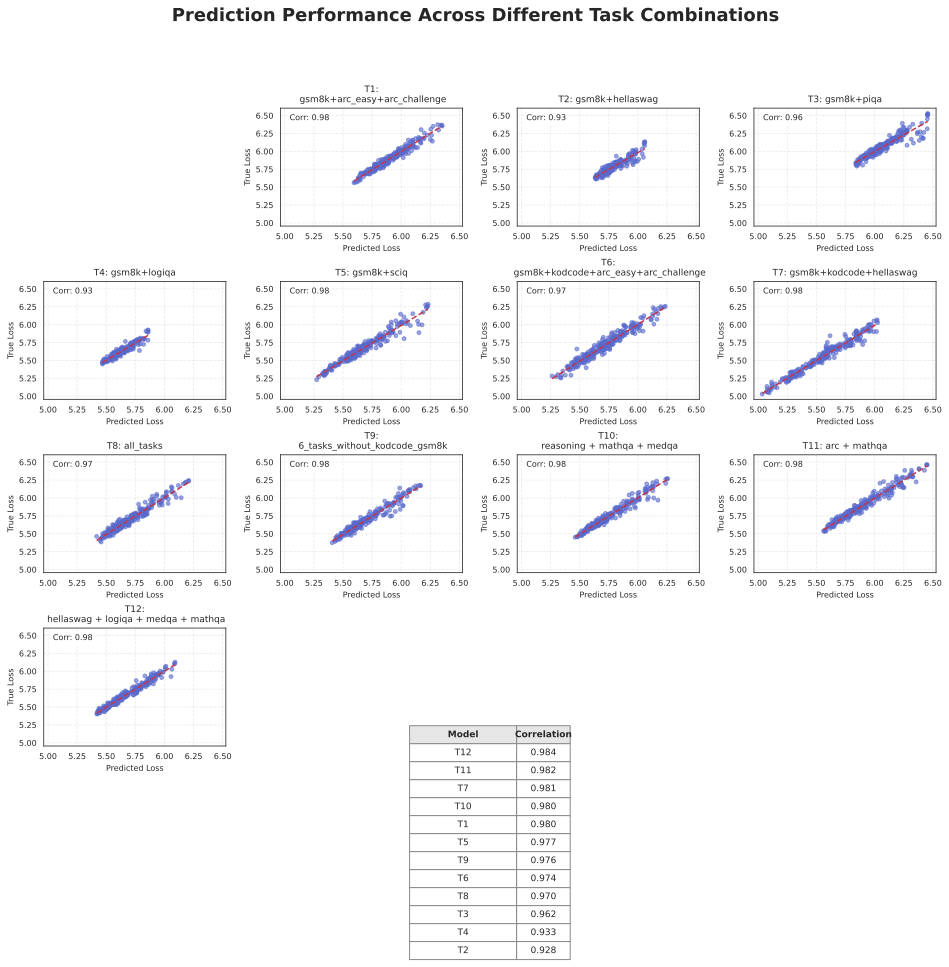

Visualization complete.


In [51]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.stats import spearmanr
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap

# Set basic parameters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 10

# Function to create visualization for a specific target
def create_subplot(ax, predictor, X_test, y_true, title, y_min=None, y_max=None, x_min=None, x_max=None):
    y_pred = predictor.predict(X_test)
    
    ax.scatter(y_pred, y_true, s=15, color='#5969CB', alpha=0.6)
    
    m, b = np.polyfit(y_pred, y_true, 1)
    x_range = np.linspace(min(y_pred), max(y_pred), 100)
    ax.plot(x_range, m * x_range + b, color='#C3364A', linewidth=1.5, linestyle='dashed')
    
    r, p = spearmanr(y_pred, y_true)
    ax.text(0.05, 0.95, f'Corr: {r:.2f}', transform=ax.transAxes,
            fontsize=8, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('Predicted Loss', fontsize=8)
    ax.set_ylabel('True Loss', fontsize=8)
    
    if len(title) > 30:
        parts = title.split(':')
        if len(parts) > 1:
            short_title = parts[0] + ':\n' + parts[1]
        else:
            short_title = title[:15] + '\n' + title[15:]
        ax.set_title(short_title, fontsize=9)
    else:
        ax.set_title(title, fontsize=9)
    
    if y_min is not None and y_max is not None:
        ax.set_ylim(y_min, y_max)
    if x_min is not None and x_max is not None:
        ax.set_xlim(x_min, x_max)
    
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    return r, min(y_pred), max(y_pred), min(y_true), max(y_true)

# Create figure
plt.figure(figsize=(16, 14))

grid = GridSpec(5, 4, figure=plt.gcf(), 
                height_ratios=[1, 1, 1, 1, 0.7],
                hspace=0.5,
                wspace=0.3)

# # Track correlations and axis limits
correlations = {}
y_min_global, y_max_global = float('inf'), float('-inf')
x_min_global, x_max_global = float('inf'), float('-inf')

# # Calculate global axis limits
# commoncrawl_idx = KEY_METRICS.index('metric/task_commoncrawl_val_loss')
# predictor = all_predictors['commoncrawl']
# y_true = y_test[:, commoncrawl_idx]
# y_pred = predictor.predict(X_test)
# y_min_global = min(y_min_global, min(y_true))
# y_max_global = max(y_max_global, max(y_true))
# x_min_global = min(x_min_global, min(y_pred))
# x_max_global = max(x_max_global, max(y_pred))

# positions = [
#     (0, 0), (0, 1), (0, 2), (0, 3),
#     (1, 0), (1, 1), (1, 2), (1, 3),
#     (2, 0), (2, 1), (2, 2), (2, 3),
#     (3, 0)
# ]

for (ablation_id, config), pos in zip(ablation_configs.items(), positions):
    ablation_avg_test = compute_reasoning_avg(y_test, config['metrics'])
    predictor = all_predictors[ablation_id]
    y_pred = predictor.predict(X_test)
    
    y_min_global = min(y_min_global, min(ablation_avg_test))
    y_max_global = max(y_max_global, max(ablation_avg_test))
    x_min_global = min(x_min_global, min(y_pred))
    x_max_global = max(x_max_global, max(y_pred))

# Add padding to limits
y_padding = (y_max_global - y_min_global) * 0.05
x_padding = (x_max_global - x_min_global) * 0.05
y_min_global -= y_padding
y_max_global += y_padding
x_min_global -= x_padding
x_max_global += x_padding

# # Create Commoncrawl plot
# ax = plt.subplot(grid[0, 0])
# r, _, _, _, _ = create_subplot(
#     ax=ax,
#     predictor=all_predictors['commoncrawl'],
#     X_test=X_test,
#     y_true=y_test[:, commoncrawl_idx],
#     title="Commoncrawl Loss",
#     y_min=y_min_global, y_max=y_max_global,
#     x_min=x_min_global, x_max=x_max_global
# )
# correlations['Commoncrawl'] = r

positions = [
    (0, 1), (0, 2), (0, 3),
    (1, 0), (1, 1), (1, 2), (1, 3),
    (2, 0), (2, 1), (2, 2), (2, 3),
    (3, 0)
]

# Create plots for ablation models
for (ablation_id, config), pos in zip(ablation_configs.items(), positions):
    ablation_avg_test = compute_reasoning_avg(y_test, config['metrics'])
    ax = plt.subplot(grid[pos[0], pos[1]])
    
    if len(config['name']) > 50:
        title = f"{ablation_id}"
    else:
        title = f"{ablation_id}: {config['name']}"
    
    r, _, _, _, _ = create_subplot(
        ax=ax,
        predictor=all_predictors[ablation_id],
        X_test=X_test,
        y_true=ablation_avg_test,
        title=title,
        y_min=y_min_global, y_max=y_max_global,
        x_min=x_min_global, x_max=x_max_global
    )
    correlations[ablation_id] = r

# Create table
ax = plt.subplot(grid[4, :])
ax.axis('off')

sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
table_data = [["Model", "Correlation"]]
for model, corr in sorted_correlations:
    table_data.append([model, f"{corr:.3f}"])

table = ax.table(
    cellText=table_data[1:],
    colLabels=table_data[0],
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

for (row, col), cell in table.get_celld().items():
    if col == 0:
        cell.set_width(0.12)
    elif col == 1:
        cell.set_width(0.06)
        
    if row == 0:
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#E6E6E6')
    cell.set_edgecolor('#888888')


plt.suptitle("Prediction Performance Across Different Task Combinations", 
            fontsize=18, y=0.98, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('prediction_performance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Visualization complete.")

# Simulate

Sample shape: (100000, 20)

Running simulations for each ablation configuration...

Simulating for T1...
Top-128 samples shape: (128, 20)

Optimal data mixture for T1 - gsm8k+arc_easy+arc_challenge:
Domain  gsm8k+arc_easy+arc_challenge Weight
     1                             0.083588
     2                             0.000769
     3                             0.009039
     4                             0.011211
     5                             0.008477
     6                             0.038154
     7                             0.028930
     8                             0.047043
     9                             0.006997
    10                             0.002712
    11                             0.020851
    12                             0.019830
    13                             0.013423
    14                             0.000406
    15                             0.003939
    16                             0.018962
    17                             0.651111
    18   

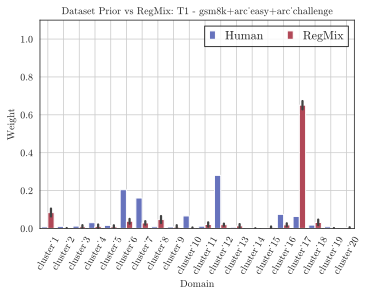


Simulating for T2...
Top-128 samples shape: (128, 20)

Optimal data mixture for T2 - gsm8k+hellaswag:
Domain  gsm8k+hellaswag Weight
     1                0.308017
     2                0.011164
     3                0.010430
     4                0.282690
     5                0.014505
     6                0.111885
     7                0.068993
     8                0.002895
     9                0.002405
    10                0.010748
    11                0.004800
    12                0.067324
    13                0.003589
    14                0.000532
    15                0.001218
    16                0.056755
    17                0.036425
    18                0.004045
    19                0.000976
    20                0.000602
train_dw: "0.31,0.01,0.01,0.28,0.01,0.11,0.07,0.00,0.00,0.01,0.00,0.07,0.00,0.00,0.00,0.06,0.04,0.00,0.00,0.00"


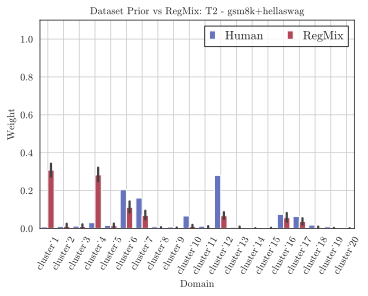


Simulating for T3...
Top-128 samples shape: (128, 20)

Optimal data mixture for T3 - gsm8k+piqa:
Domain  gsm8k+piqa Weight
     1       5.786690e-02
     2       1.641039e-03
     3       1.575924e-03
     4       7.182606e-01
     5       6.807722e-03
     6       3.159527e-02
     7       2.273677e-02
     8       3.554164e-03
     9       4.685215e-04
    10       1.572823e-02
    11       1.941398e-02
    12       1.292816e-02
    13       1.582541e-03
    14       2.407876e-08
    15       2.278912e-06
    16       6.400959e-02
    17       2.122403e-02
    18       1.669246e-02
    19       3.706851e-03
    20       2.049416e-04
train_dw: "0.06,0.00,0.00,0.72,0.01,0.03,0.02,0.00,0.00,0.02,0.02,0.01,0.00,0.00,0.00,0.06,0.02,0.02,0.00,0.00"


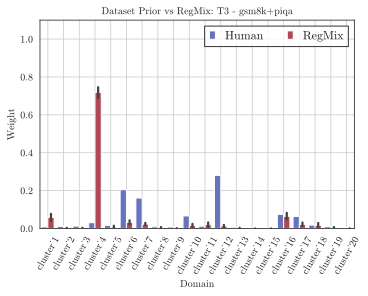


Simulating for T4...
Top-128 samples shape: (128, 20)

Optimal data mixture for T4 - gsm8k+logiqa:
Domain  gsm8k+logiqa Weight
     1         3.165315e-01
     2         2.452330e-03
     3         1.046934e-02
     4         2.944343e-02
     5         1.279379e-02
     6         7.944248e-02
     7         8.152047e-02
     8         5.186808e-03
     9         1.018577e-02
    10         1.558462e-02
    11         2.059042e-02
    12         5.421512e-02
    13         1.811997e-02
    14         5.036107e-12
    15         3.938085e-05
    16         2.420141e-01
    17         8.575516e-02
    18         1.377834e-02
    19         1.565237e-03
    20         3.117690e-04
train_dw: "0.32,0.00,0.01,0.03,0.01,0.08,0.08,0.01,0.01,0.02,0.02,0.05,0.02,0.00,0.00,0.24,0.09,0.01,0.00,0.00"


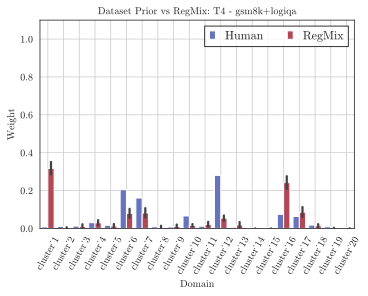


Simulating for T5...
Top-128 samples shape: (128, 20)

Optimal data mixture for T5 - gsm8k+sciq:
Domain  gsm8k+sciq Weight
     1           0.216525
     2           0.001352
     3           0.007793
     4           0.014689
     5           0.003904
     6           0.058245
     7           0.054630
     8           0.015146
     9           0.000492
    10           0.005978
    11           0.008682
    12           0.043664
    13           0.004947
    14           0.000044
    15           0.000004
    16           0.031686
    17           0.520304
    18           0.008548
    19           0.001847
    20           0.001520
train_dw: "0.22,0.00,0.01,0.01,0.00,0.06,0.05,0.02,0.00,0.01,0.01,0.04,0.00,0.00,0.00,0.03,0.52,0.01,0.00,0.00"


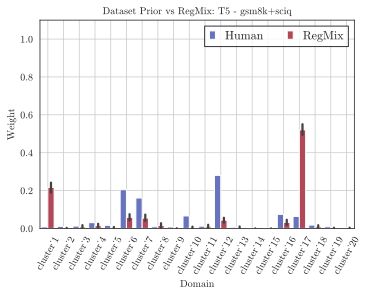


Simulating for T6...
Top-128 samples shape: (128, 20)

Optimal data mixture for T6 - gsm8k+kodcode+arc_easy+arc_challenge:
Domain  gsm8k+kodcode+arc_easy+arc_challenge Weight
     1                                     0.006856
     2                                     0.000704
     3                                     0.397250
     4                                     0.012169
     5                                     0.003446
     6                                     0.067384
     7                                     0.017794
     8                                     0.008378
     9                                     0.002544
    10                                     0.023775
    11                                     0.004918
    12                                     0.055339
    13                                     0.000411
    14                                     0.000005
    15                                     0.002954
    16                                     0

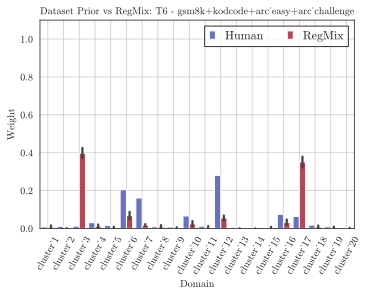


Simulating for T7...
Top-128 samples shape: (128, 20)

Optimal data mixture for T7 - gsm8k+kodcode+hellaswag:
Domain  gsm8k+kodcode+hellaswag Weight
     1                        0.016655
     2                        0.009360
     3                        0.381863
     4                        0.135844
     5                        0.016841
     6                        0.080794
     7                        0.045479
     8                        0.007928
     9                        0.013325
    10                        0.027209
    11                        0.021702
    12                        0.071696
    13                        0.002180
    14                        0.000002
    15                        0.009513
    16                        0.047702
    17                        0.020065
    18                        0.068503
    19                        0.023306
    20                        0.000033
train_dw: "0.02,0.01,0.38,0.14,0.02,0.08,0.05,0.01,0.01,0.03,0.02,0.07

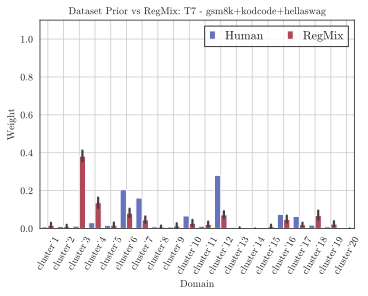


Simulating for T8...
Top-128 samples shape: (128, 20)

Optimal data mixture for T8 - all_tasks:
Domain  all_tasks Weight
     1          0.006036
     2          0.034062
     3          0.238974
     4          0.017416
     5          0.001234
     6          0.076331
     7          0.031977
     8          0.010601
     9          0.071000
    10          0.021440
    11          0.001334
    12          0.062586
    13          0.002217
    14          0.000010
    15          0.000251
    16          0.026217
    17          0.363829
    18          0.011325
    19          0.022265
    20          0.000895
train_dw: "0.01,0.03,0.24,0.02,0.00,0.08,0.03,0.01,0.07,0.02,0.00,0.06,0.00,0.00,0.00,0.03,0.36,0.01,0.02,0.00"


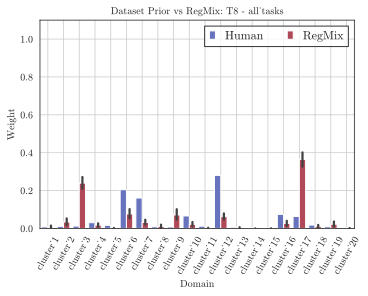


Simulating for T9...
Top-128 samples shape: (128, 20)

Optimal data mixture for T9 - 6_tasks_without_kodcode_gsm8k:
Domain  6_tasks_without_kodcode_gsm8k Weight
     1                              0.001563
     2                              0.007848
     3                              0.002416
     4                              0.188810
     5                              0.006175
     6                              0.034351
     7                              0.021946
     8                              0.019910
     9                              0.012707
    10                              0.003418
    11                              0.006577
    12                              0.021427
    13                              0.000167
    14                              0.000034
    15                              0.020726
    16                              0.008780
    17                              0.622839
    18                              0.017397
    19                      

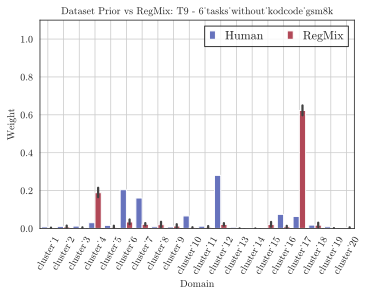


Simulating for T10...
Top-128 samples shape: (128, 20)

Optimal data mixture for T10 - reasoning + mathqa + medqa:
Domain  reasoning + mathqa + medqa Weight
     1                           0.000591
     2                           0.009594
     3                           0.003803
     4                           0.027060
     5                           0.002049
     6                           0.074459
     7                           0.034467
     8                           0.005605
     9                           0.272007
    10                           0.012113
    11                           0.004463
    12                           0.043743
    13                           0.000165
    14                           0.000291
    15                           0.000017
    16                           0.017127
    17                           0.471392
    18                           0.013980
    19                           0.004258
    20                           0.002817
tr

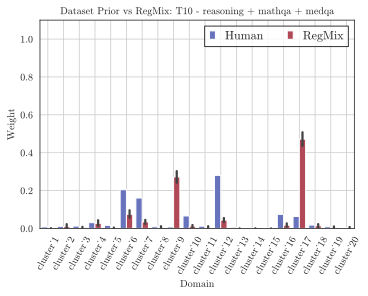


Simulating for T11...
Top-128 samples shape: (128, 20)

Optimal data mixture for T11 - arc + mathqa:
Domain  arc + mathqa Weight
     1             0.003933
     2             0.004045
     3             0.003953
     4             0.006202
     5             0.003457
     6             0.070405
     7             0.031109
     8             0.005551
     9             0.278822
    10             0.016706
    11             0.004435
    12             0.051972
    13             0.000159
    14             0.000295
    15             0.000017
    16             0.014516
    17             0.483383
    18             0.013959
    19             0.004444
    20             0.002637
train_dw: "0.00,0.00,0.00,0.01,0.00,0.07,0.03,0.01,0.28,0.02,0.00,0.05,0.00,0.00,0.00,0.01,0.48,0.01,0.00,0.00"


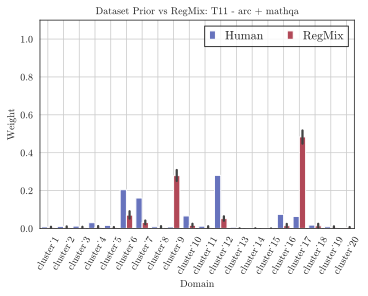


Simulating for T12...
Top-128 samples shape: (128, 20)

Optimal data mixture for T12 - hellaswag + logiqa + medqa + mathqa:
Domain  hellaswag + logiqa + medqa + mathqa Weight
     1                                    0.030608
     2                                    0.017930
     3                                    0.040040
     4                                    0.040047
     5                                    0.004811
     6                                    0.050262
     7                                    0.068174
     8                                    0.003170
     9                                    0.473447
    10                                    0.014810
    11                                    0.006573
    12                                    0.056804
    13                                    0.001565
    14                                    0.000409
    15                                    0.000939
    16                                    0.132446
    17  

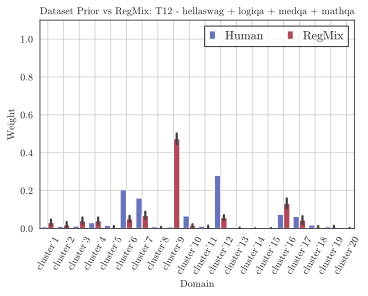


Simulating for T13...
Top-128 samples shape: (128, 20)

Optimal data mixture for T13 - medqa:
Domain  medqa Weight
     1      0.000550
     2      0.003175
     3      0.000354
     4      0.001101
     5      0.001378
     6      0.022547
     7      0.034174
     8      0.002010
     9      0.882497
    10      0.002222
    11      0.002979
    12      0.026547
    13      0.001084
    14      0.000225
    15      0.000425
    16      0.005181
    17      0.008567
    18      0.002986
    19      0.000923
    20      0.001075
train_dw: "0.00,0.00,0.00,0.00,0.00,0.02,0.03,0.00,0.88,0.00,0.00,0.03,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00"


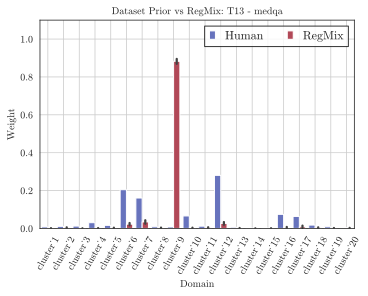

In [ ]:
# Simulation for different metrics with dataset distribution
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml

# Set random seed for reproducibility
np.random.seed(42)

# dataset domain names and distribution
train_domains = [
    f"train_cluster_{i}" for i in range(1, 21)
]

# Domain short names for JSON format
domain_short_names = [
    f"cluster_{i}" for i in range(1, 21)
]

# dataset original distribution weights
dataset_prior_dist = [
        0.0081, 0.0111, 0.0126, 0.0305, 0.0165, 0.2046, 0.1608, 0.0091, 0.0078, 
        0.066, 0.012, 0.2804, 0.0063, 0.0021, 0.0021, 0.0745, 0.0635, 0.0179, 
        0.0091, 0.0049
    ]
# [
    # 0.0152, 0.0937, 0.0689, 0.0553, 0.0794, 0.0606, 0.0547, 0.0211, 0.0109, 
    # 0.1157, 0.0317, 0.0669, 0.0094, 0.0134, 0.0301, 0.0446, 0.0703, 0.0462, 
    # 0.0430, 0.0679
# ]

    

# Generate samples from Dirichlet distribution based on dataset distribution
samples = np.random.dirichlet(np.array(dataset_prior_dist) * 1, 100000)
print(f"Sample shape: {samples.shape}")

# Function to simulate and visualize for a specific metric
def simulate_and_visualize(predictor, ablation_id, k=128):
    if ablation_id == 'commoncrawl':
       config = ablation_configs['T8']
       metric_name = 'Commoncrawl'
    else:
        config = ablation_configs[ablation_id]
        metric_name = config['name']
    
    # Predict using the given model
    simulation = predictor.predict(samples)
    
    # Histogram of predictions
    plt.figure(figsize=(10, 6))
    plt.hist(simulation, bins=32)
    plt.xlabel('Pred Loss')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Predicted {metric_name} Loss')
    plt.savefig(f'../misc/dataset_hist_{ablation_id.lower()}.png')
    plt.close()
    
    # Find optimal data mixture (top-k samples with lowest predicted loss)
    top_k_indices = np.argsort(simulation)[:k]
    top_k_samples = samples[top_k_indices]
    print(f"Top-{k} samples shape: {top_k_samples.shape}")
    
    optimal_data_mixture = np.mean(top_k_samples, axis=0)
    
    optimal_mix_df = pd.DataFrame({
        'Domain': [domain.split('train_cluster_')[-1] for domain in train_domains],
        f'{metric_name} Weight': optimal_data_mixture
    })

    print(f"\nOptimal data mixture for {ablation_id} - {metric_name}:")
    print(optimal_mix_df.to_string(index=False))
    
    # Generate JSON-ready train_dw string
    train_dw = ",".join([f"{w:.2f}" for w in optimal_data_mixture])
    print(f"train_dw: \"{train_dw}\"")
    
    df = pd.DataFrame(
        data=np.concatenate([np.array([dataset_prior_dist]), top_k_samples], axis=0), 
        columns=[domain.split('train_')[-1] for domain in train_domains]
    )
    df = pd.melt(df)
    df['type'] = (['Human'] + ['RegMix'] * top_k_samples.shape[0]) * len(train_domains)
    
    plt.rc('axes', unicode_minus=False)
    plt.rcParams.update({
        'text.usetex': False,
        'font.family': 'serif',
        'font.serif': 'cmr10',
        'mathtext.fontset': 'cm',
    })
    
    fig, ax = plt.subplots(figsize=(5,4), layout='compressed')
    
    pal = {
        'Human': '#5969CB',
        'RegMix': '#C3364A',
    }
    
    sns.barplot(
        data=df,
        x='variable',
        y='value',
        hue='type',
        palette=pal
    )
    
    ax.tick_params(axis='x', labelrotation=60, labelsize=10)
    ax.legend(
        edgecolor='black',
        fancybox=False,
        prop={'size': 12},
        handlelength=0.5,
        ncol=2,
    )
    
    ax.grid(True)
    ax.set_ylim(0, 1.1, )
    ax.set_xlabel('Domain', fontdict={'size': 10}) 
    ax.set_ylabel('Weight', fontdict={'size': 10})  
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(f'Dataset Prior vs RegMix: {ablation_id} - {metric_name}', fontdict={'size': 10})  
    plt.show()
    plt.close()
    
    optimal_mixture_dict = {}
    for domain, weight in zip(train_domains, optimal_data_mixture):
        optimal_mixture_dict[domain] = float(weight)
    
    optimal_df = pd.DataFrame({
        'Domain': train_domains,
        'Weight': optimal_data_mixture
    })

    json_config = {
        "dataset": f"climb-{'-'.join(config['metrics'])}",
        "train_domains": ",".join(domain_short_names),
        "tgt_domains": ','.join(config['metrics']),
        "max_steps": 20000,
        "train_dw": train_dw,
        "tgt_dw": None,
        "val_dw": None,
        "max_train_samples": None,
        "max_eval_samples": 5000,
        "max_token_length": 512,
        "seed": 16,
        "preprocessing_num_workers": 2,
        "model_name_or_path": None,
        "model_type": "gpt2",
        "config_overrides": "n_positions=512,n_embd=768,n_layer=12,n_head=12",
        "run_name": f"REGMIX-125M",
        "output_dir": "FILL_IN",
        "do_train": True,
        "do_eval": True,
        "do_predict": False,
        "learning_rate": 0.0005,
        "weight_decay": 0.01,
        "reweight_train": "None",
        "reweight_tgt": "None",
        "reweight_train_iters": -1,
        "reweight_tgt_iters": -1,
        "ref_model": None,
        "lr_scheduler_name": "linear_warmup_cosine",
        "lr_end": 0.0001,
        "reweight_eps": 0.0,
        "mu_train": 0.001,
        "mu_tgt": 0.0002,
        "max_grad_norm": 5.0,
        "per_device_train_batch_size": 16,
        "warmup_ratio": 0.05,
        "warmup_steps": 500,
        "save_steps": 5000,
        "eval_steps": 500,
        "gradient_accumulation_steps": 2,
        "save_strategy": "steps",
        "evaluation_strategy": "steps",
        "logging_steps": 50,
        "save_total_limit": 10,
        "ddp_find_unused_parameters": False,
        "use_cpu": False,
        "compute_pertoken_losses": False,
        "overwrite_output_dir": False
    }
    
    with open(f'../misc/configs/{ablation_id}-regmix.json', 'w') as f:
        import json
        json.dump(json_config, f, indent=2)
    
    return optimal_data_mixture, optimal_mixture_dict, json_config

print("\nRunning simulations for each ablation configuration...")
optimal_mixtures = {}
optimal_mixture_dicts = {}
json_configs = {}


for ablation_id, predictor in all_predictors.items():
    if ablation_id in ablation_configs:
        print(f"\nSimulating for {ablation_id}...")
        optimal_mixtures[ablation_id], optimal_mixture_dicts[ablation_id], json_configs[ablation_id] = simulate_and_visualize(predictor, ablation_id)



KeyError: 'commoncrawl'

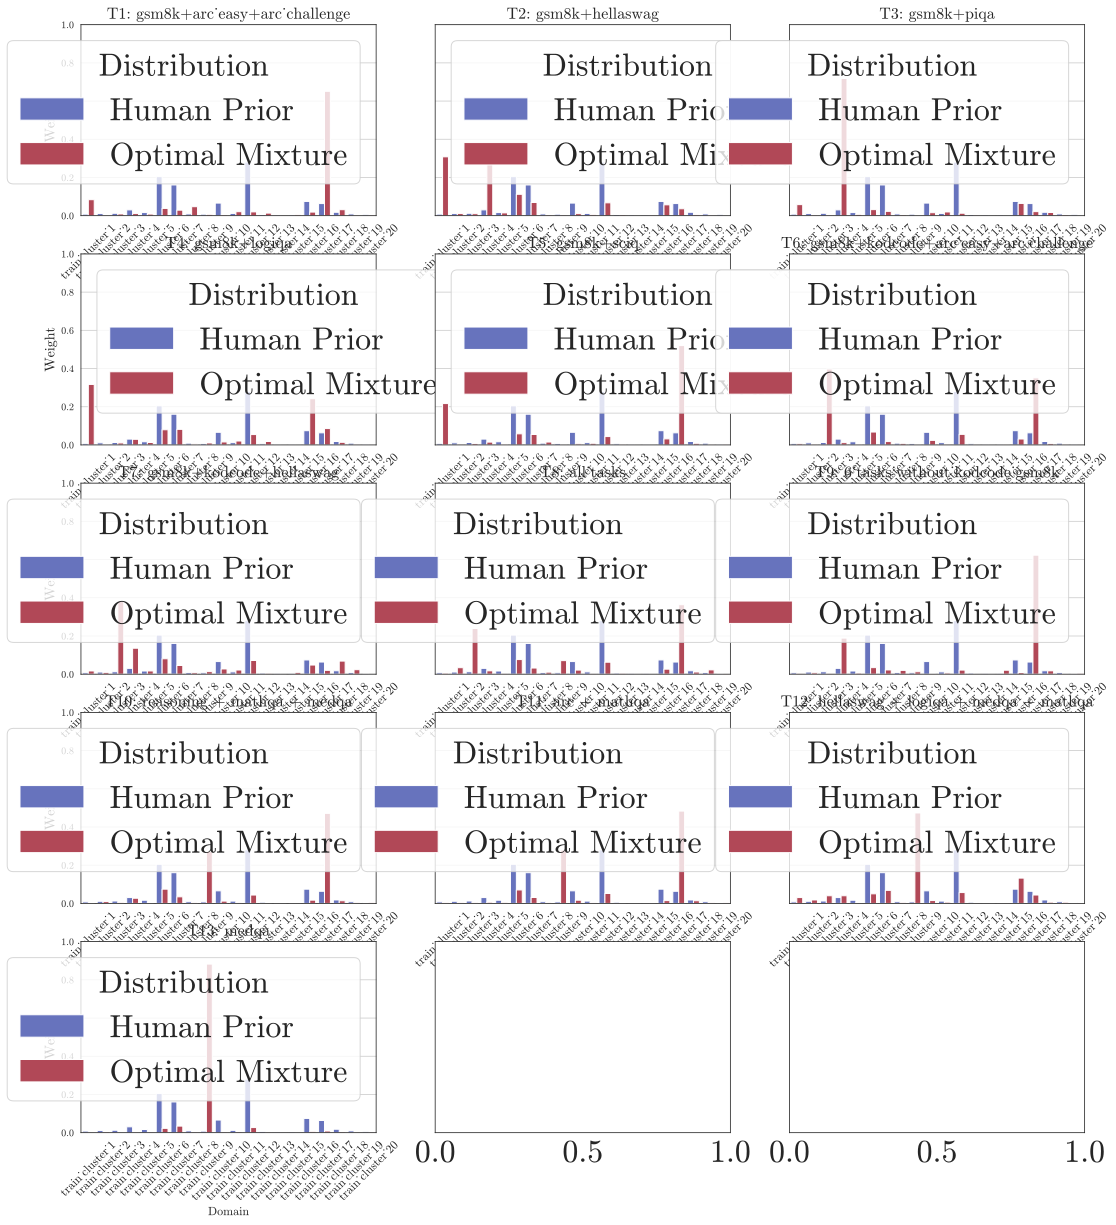

In [53]:
def plot_all_ablations_comparison():
    """
    Create a single plot with subplots for each ablation configuration compared to "human" weights.
    """
    t_ablations = {k: v for k, v in ablation_configs.items() if k.startswith('T')}
    n_ablations = len(t_ablations) + 1
    
    n_cols = 3
    n_rows = (n_ablations + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharey=True)
    axes = axes.flatten()
    
    # Set up domain labels for x-axis (shorter names for better display)
    domain_labels = [domain.split('train_dataset_')[-1] for domain in train_domains]
    
    pal = {
        'Human Prior': '#5969CB',
        'Optimal Mixture': '#C3364A',
    }
    
    
    # Plot each ablation configuration
    for i, (ablation_id, config) in enumerate(t_ablations.items()):
        if i < len(axes) and ablation_id in optimal_mixtures:
            ax = axes[i]
            
            plot_df = pd.DataFrame({
                'Domain': domain_labels,
                'Human Prior': dataset_prior_dist,
                'Optimal Mixture': optimal_mixtures[ablation_id]
            })
            
            plot_df_melted = pd.melt(plot_df, id_vars=['Domain'], 
                                    value_vars=['Human Prior', 'Optimal Mixture'], 
                                    var_name='Distribution', value_name='Weight')
            
            sns.barplot(data=plot_df_melted, x='Domain', y='Weight', hue='Distribution', 
                        palette=pal, ax=ax)
            
            ax.set_title(f'{ablation_id}: {config["name"]}', fontsize=16)
            ax.set_ylim(0, 1)  
            ax.tick_params(axis='x', rotation=45, labelsize=12)
            ax.tick_params(axis='y', labelsize=10)
            # Only show y-label on the leftmost subplots
            if i % n_cols == 0:
                ax.set_ylabel('Weight', fontsize=14)
            else:
                ax.set_ylabel('')
            
            ax.set_xlabel('Domain', fontsize=12)
            ax.grid(True, axis='y')

    # add commoncrawl
    ax = axes[-1]  
    plot_df = pd.DataFrame({
        'Domain': domain_labels,
        'Human Prior': dataset_prior_dist,
        'Optimal Mixture': optimal_mixtures['commoncrawl']
    })
    plot_df_melted = pd.melt(plot_df, id_vars=['Domain'],
                            value_vars=['Human Prior', 'Optimal Mixture'], 
                            var_name='Distribution', value_name='Weight')
    sns.barplot(data=plot_df_melted, x='Domain', y='Weight', hue='Distribution',
                palette=pal, ax=ax)
    ax.set_title(f'Commoncrawl', fontsize=16)
    ax.set_ylim(0, 1)  
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylabel('Weight', fontsize=14)
    ax.set_xlabel('Domain', fontsize=12)
    ax.grid(True, axis='y')
    

    # Hide any unused subplots
    for i in range(len(t_ablations), len(axes)):
        axes[i].set_visible(False)
    axes[-1].set_visible(True)  # Ensure the last one is visible
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=14, 
               fancybox=False, edgecolor='black', bbox_to_anchor=(0.5, 1.05))
    
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()
    
    fig.suptitle('dataset Human Prior vs Optimal Mixture Weights Across Ablations', fontsize=20)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('../misc/all_ablations_comparison.png', 
                bbox_inches='tight', pad_inches=0.1, dpi=300)
    
    plt.close()

def plot_all_weights_in_single_barplot():
    """
    Create a single barplot showing all the different domain weights for each configuration.
    """
    domain_labels = [domain.split('train_dataset_')[-1] for domain in train_domains]
    
    t_ablations = {k: v for k, v in ablation_configs.items() if k.startswith('T')}
    
    plot_data = {'Domain': [], 'Distribution': [], 'Weight': []}
    
    for domain, weight in zip(domain_labels, dataset_prior_dist):
        plot_data['Domain'].append(domain)
        plot_data['Distribution'].append('Human Prior')
        plot_data['Weight'].append(weight)
    
    for ablation_id, config in t_ablations.items():
        if ablation_id in optimal_mixtures:
            for domain, weight in zip(domain_labels, optimal_mixtures[ablation_id]):
                plot_data['Domain'].append(domain)
                plot_data['Distribution'].append(f'{ablation_id} Optimal')
                plot_data['Weight'].append(weight)
    
    plot_df = pd.DataFrame(plot_data)
    
    distributions = ['Human Prior'] + [f'{aid} Optimal' for aid in t_ablations.keys() if aid in optimal_mixtures]
    colors = ['#5969CB', '#C3364A', '#FF9800', '#4CAF50', '#9C27B0', 
              '#2196F3', '#F44336', '#FFEB3B', '#795548', '#03A9F4', 
              '#673AB7', '#FFC107', '#009688', '#E91E63']
    pal = {dist: color for dist, color in zip(distributions, colors[:len(distributions)])}
    
    plt.figure(figsize=(10, 9))
    
    ax = sns.barplot(data=plot_df, x='Domain', y='Weight', hue='Distribution', 
                    palette=pal)
    
    ax.set_title(' Domain Weight Comparison Across All Ablation Configurations', fontsize=20)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Domain', fontsize=16)
    ax.set_ylabel('Weight', fontsize=16)
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True, axis='y')
    
    plt.legend(title='Distribution', fontsize=8, title_fontsize=14,
               edgecolor='black', fancybox=False, ncol=2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    plt.savefig('../misc/all_optimal_weights_comparison.png', 
                bbox_inches='tight', pad_inches=0.1, dpi=300)
    
    plt.close()

plot_all_ablations_comparison()
plot_all_weights_in_single_barplot()

print("dataset simulation with ablation configurations complete. Config files and plots saved as PNG.")